<h1> Финальный проект </h1>

Прогнозирование временных рядов на карте

<h2>Анализ поездок желтого такси</h2>
<h3>Часть 1: Предобработка данных<h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d 
from mpl_toolkits.mplot3d import Axes3D
from skimage import io

In [2]:
raw = pd.read_csv('yellow_tripdata_2016-05.csv')
raw.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [3]:
#удаляем лишние столбцы
raw = raw.drop(['VendorID','RatecodeID','store_and_fwd_flag','payment_type',
                'fare_amount','extra','mta_tax','tip_amount','improvement_surcharge',
                'total_amount','tolls_amount'], axis=1)

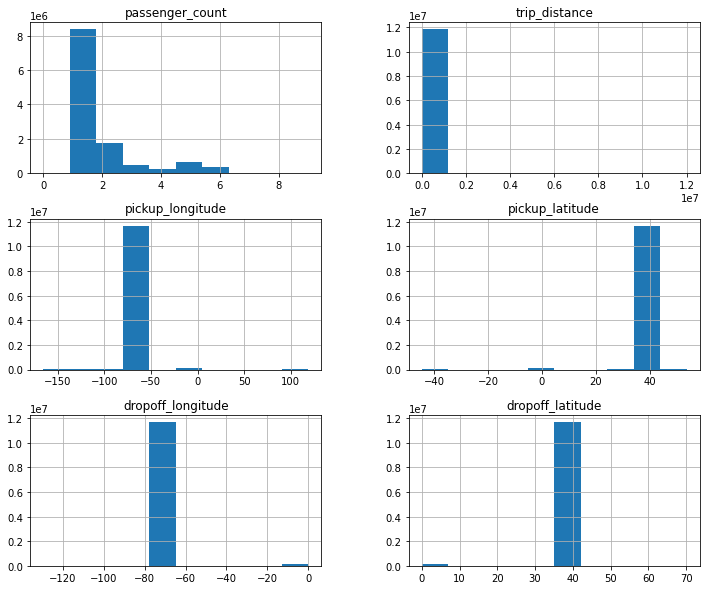

In [4]:
#взглянем на данные. Видим аномальные значения в координатах и дистанции.
raw.hist(figsize = (12,10));

In [4]:
import datetime
#парсим ячейки со временем
raw['tpep_dropoff_datetime'] = raw['tpep_dropoff_datetime'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
raw['tpep_pickup_datetime'] = raw['tpep_pickup_datetime'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

#считаем длительность поездки
raw['duration'] = raw['tpep_dropoff_datetime']-raw['tpep_pickup_datetime']

#количество строк
print('количество поездок:'+str(len(raw.index)))

количество поездок:11836853


In [5]:
#удаляем поездки с нулевой длительностью
data = raw.loc[raw['duration'] != datetime.timedelta(0,0)]
tmp=(len(raw.index)-len(data.index))
print('удалено поездок:'+str(tmp))

удалено поездок:12268


In [6]:
#удаляем поездки с нулевым количеством пассажиров
tmp = len(data.index)
data = data.loc[data['passenger_count'] != 0]
print('удалено поездок:'+str(tmp - len(data.index)))

удалено поездок:522


In [7]:
#удаляем поездки с нулевой дистанцией
tmp = len(data.index)
data = data.loc[(data['trip_distance'] != 0)]# & (data['trip_distance'] < 100)]
print('удалено поездок:'+str(tmp - len(data.index)))

удалено поездок:60641


In [8]:
#удаляем поездки с аномальными координатами
tmp = len(data.index)
NY_coords = [[-74.25559, -73.70001],[40.49612, 40.91553]]
data = data.loc[(data['pickup_longitude'] > NY_coords[0][0]) &
             (data['pickup_longitude'] < NY_coords[0][1]) &
             (data['pickup_latitude'] > NY_coords[1][0]) &
             (data['pickup_latitude'] < NY_coords[1][1])]

"""data = data.loc[(data['dropoff_longitude'] > NY_coords[0][0]) &
             (data['dropoff_longitude'] < NY_coords[0][1]) &
             (data['dropoff_latitude'] > NY_coords[1][0]) &
             (data['dropoff_latitude'] < NY_coords[1][1])]
"""
print('удалено поездок:'+str(tmp - len(data.index)))

удалено поездок:136901


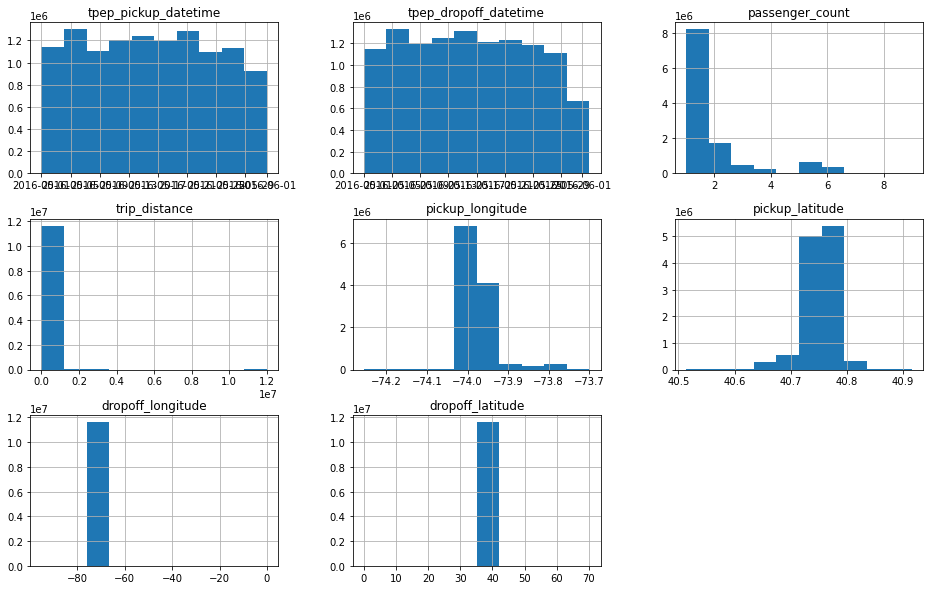

In [10]:
data.hist(figsize = (16,10));
#теперь с координатами поездки все в порядке.   

In [9]:
#добавим в данные столбец, содержащий количество часов от начала отсчета (00:00:00 01.05.2016)
data['pickup_hour'] = data['tpep_pickup_datetime'].map(lambda x: (x-datetime.datetime(2016,5,1)).total_seconds()/3600)

<h3>Часть 2: Агрегация по регионам</h3>

In [10]:
#считываем координаты ячеек
bins = pd.read_csv('regions.csv',sep=';')
bins.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [11]:
#создаем сетку для агрегации
x_bins = list(bins.west[list(range(0,2499,50))])
y_bins = list(bins.south[list(range(0,50))])
x_bins.append(bins.east[2499])
y_bins.append(bins.north[49])
t_bins = list(range(0,(datetime.datetime(2016,6,1)-datetime.datetime(2016,5,1)).days*24))
t_bins.append(t_bins[-1]+1)
print(len(x_bins),len(y_bins),len(t_bins))

51 51 745


In [12]:
#агрегируем данные по регионам за все время
'''from scipy.stats import binned_statistic_2d
stat = binned_statistic_2d(data['pickup_longitude'].values,
                           data['pickup_latitude'].values,
                           None,'count',bins=[x_bins,y_bins])

maxnum = max(stat.statistic.ravel())
print('Наибольшее кол-во: {0}\nКоличество регионов: {1}'.format(maxnum,stat.statistic.shape))'''

#агрегируем данные по регионам и часам
from scipy.stats import binned_statistic_dd
stat = binned_statistic_dd([data['pickup_longitude'].values,
                            data['pickup_latitude']. values,
                            data['pickup_hour'].values],
                            None,'count',bins=[x_bins,y_bins,t_bins])

maxnum = max(stat.statistic.ravel())
print('Наибольшее кол-во: {0}\nКоличество регионов: {1}'.format(maxnum,stat.statistic.shape))

Наибольшее кол-во: 2206.0
Количество регионов: (50, 50, 744)


<b>Задание 1</b> Выведем первые строки полученной таблицы

In [13]:
#сначала сделаем таблицу в формате {регионы*часы}
aggregated = pd.DataFrame(stat.statistic.reshape(744,2500))

In [14]:
aggregated['hour'] = range(744)
aggregated

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,hour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,739
740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,740
741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,741
742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,742


In [19]:
#и преобразуем к требуемому виду {час / регион / счетчик}
# здесь только для первых 20ти регионов
output = pd.melt(aggregated, id_vars='hour',
                 value_vars=list(aggregated.columns[:20]),
                 var_name = 'region',
                 value_name = 'trip_count')
output.set_index('hour', inplace = True)
output

,region,trip_count
hour,,
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
739,19,0.0
740,19,0.0
741,19,0.0


<b>Задание 2</b> Построим график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [43]:
# Координаты  Empire State Building
target = (40.748441, -73.985664)
# Найдем соответствующую ячейку
target_region = bins.loc[(bins.west<=target[1])&(bins.east>target[1])&(bins.south<=target[0])&(bins.north>target[0])]
target_region

,region,west,east,south,north
1230,1231,-73.988912,-73.9778,40.747766,40.756154


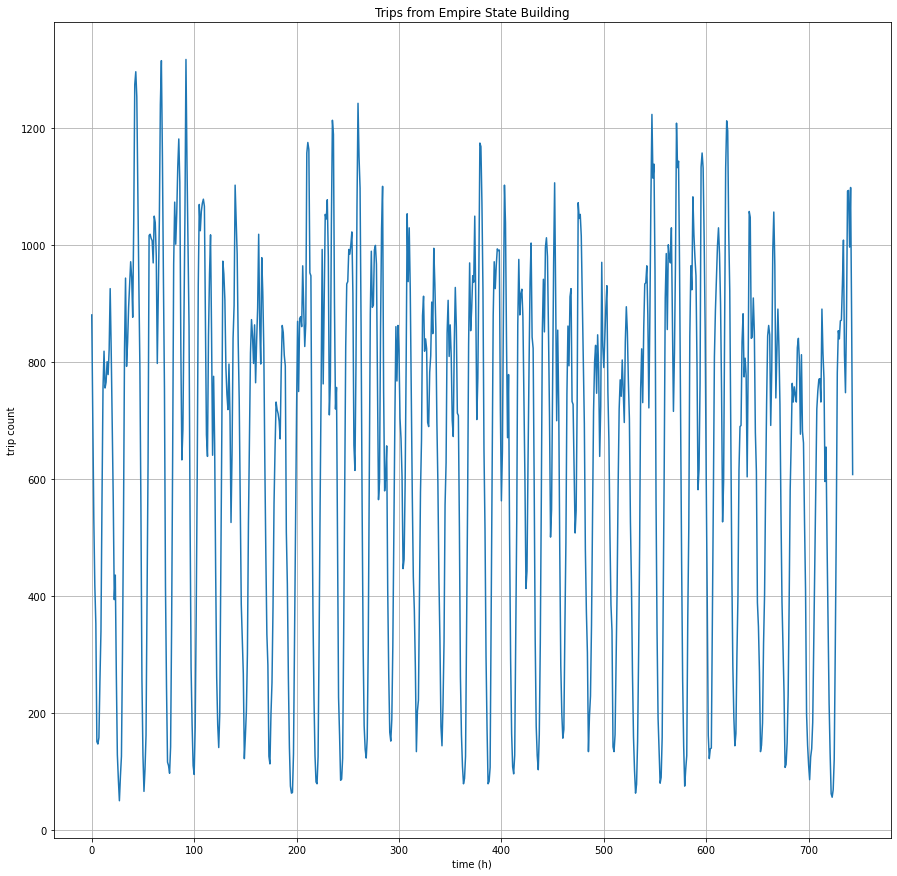

In [44]:
#Строим график
fig, ax = plt.subplots(figsize = (15,15))
ax.plot(aggregated.iloc[target_region.region-1].values.ravel())
ax.set(xlabel='time (h)', ylabel='trip count',
       title='Trips from Empire State Building')
ax.grid()
plt.show()

Видим выраженные суточную и недельную периодичности

<b>Задание 3</b> Подсчитаем количество пар час-ячейка, для укоторых не было совершено ни одной поездки.

In [58]:
aggregated.stack().value_counts().to_dict()[0.0]

1718238

Ячеек с нулевым значением 1718238 штук